# sentiment analysis model

Here i will build my own sentment analysis model to be replaced with textblob 

## uploading the dataset form kaggle 

[Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140)

In [2]:
# uploading the kagle API token 
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kerolis","key":"1c8935297815f71809aa8f2fa5e798eb"}'}

In [3]:
# Downloading and unzipping the dataset from kaggle
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kazanova/sentiment140
! mkdir train
! unzip sentiment140.zip -d train

## Extracting the dataset from the downladed file

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)


Tensorflow Version 2.8.2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
# the encoding utf-8 is not valid while reading the csv so I used the latin 
df = pd.read_csv('/content/train/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [15]:
# Giving names to the cloumns
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [16]:
# dropping the unnessary columns 
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [17]:
# decoding the labels for analysis
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()


,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [18]:
df['sentiment'].unique()

array(['Negative', 'Positive'], dtype=object)

Here we can see that our dataset is balanced 

Text(0.5, 1.0, 'Sentiment Data Distribution')

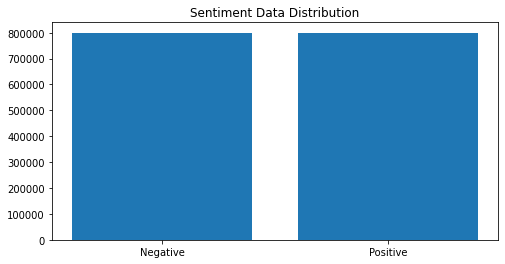

In [19]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

## Preprocessing and data cleaning

Here we will clean the dataset from the stopwords and noisy punctuation.


In [21]:
stop_words = stopwords.words('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [22]:
def preprocess(text):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      tokens.append(token)
  return " ".join(tokens)

In [25]:
df.text = df.text.apply(lambda x: preprocess(x))

## Data splitting

In [26]:
# splitting the data into tarin , test sets 
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [27]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) 
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


## Tokenizing and padding the sequncess for training and testing the model  

In [28]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [29]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [30]:
# Encoding the label into numircal values 
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


## Word Embbiding 

In [31]:
# downlaoding the pretrained glove embedding
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-06-25 18:38:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-06-25 18:38:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-06-25 18:38:38--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [34]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [35]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [36]:
# building the embedding_matrix
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [37]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

## The model 

In [39]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [40]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [44]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           87172500  
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

## Model training

In [41]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
# reducing the learning rate when the model is not learning
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)
# a builtin callback saves the best model when the accuracy is improved on the validation set  
save_best_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='Best_model',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [42]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau,save_best_model])

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 0.5196 - accuracy: 0.7390
Epoch 1: val_accuracy improved from -inf to 0.76621, saving model to Best_model
INFO:tensorflow:Assets written to: Best_model/assets


1250/1250 [==============================] - 173s 126ms/step - loss: 0.5196 - accuracy: 0.7390 - val_loss: 0.4819 - val_accuracy: 0.7662 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4876 - accuracy: 0.7622
Epoch 2: val_accuracy improved from 0.76621 to 0.77144, saving model to Best_model
INFO:tensorflow:Assets written to: Best_model/assets


INFO:tensorflow:Assets written to: Best_model/assets


1250/1250 [==============================] - 158s 126ms/step - loss: 0.4876 - accuracy: 0.7622 - val_loss: 0.4754 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.7692
Epoch 3: val_accuracy improved from 0.77144 to 0.77567, saving model to Best_model
INFO:tensorflow:Assets written to: Best_model/assets


INFO:tensorflow:Assets written to: Best_model/assets


1250/1250 [==============================] - 155s 124ms/step - loss: 0.4776 - accuracy: 0.7692 - val_loss: 0.4669 - val_accuracy: 0.7757 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.7729
Epoch 4: val_accuracy improved from 0.77567 to 0.77714, saving model to Best_model
INFO:tensorflow:Assets written to: Best_model/assets


INFO:tensorflow:Assets written to: Best_model/assets


1250/1250 [==============================] - 175s 140ms/step - loss: 0.4714 - accuracy: 0.7729 - val_loss: 0.4652 - val_accuracy: 0.7771 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.7756
Epoch 5: val_accuracy improved from 0.77714 to 0.77831, saving model to Best_model
INFO:tensorflow:Assets written to: Best_model/assets


INFO:tensorflow:Assets written to: Best_model/assets


1250/1250 [==============================] - 187s 150ms/step - loss: 0.4668 - accuracy: 0.7756 - val_loss: 0.4617 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4637 - accuracy: 0.7775
Epoch 6: val_accuracy improved from 0.77831 to 0.77921, saving model to Best_model
INFO:tensorflow:Assets written to: Best_model/assets


INFO:tensorflow:Assets written to: Best_model/assets


1250/1250 [==============================] - 161s 129ms/step - loss: 0.4637 - accuracy: 0.7775 - val_loss: 0.4608 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 7/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4603 - accuracy: 0.7798
Epoch 7: val_accuracy improved from 0.77921 to 0.78056, saving model to Best_model
INFO:tensorflow:Assets written to: Best_model/assets


INFO:tensorflow:Assets written to: Best_model/assets


1250/1250 [==============================] - 168s 134ms/step - loss: 0.4603 - accuracy: 0.7798 - val_loss: 0.4604 - val_accuracy: 0.7806 - lr: 0.0010
Epoch 8/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4584 - accuracy: 0.7808
Epoch 8: val_accuracy improved from 0.78056 to 0.78059, saving model to Best_model
INFO:tensorflow:Assets written to: Best_model/assets


INFO:tensorflow:Assets written to: Best_model/assets


1250/1250 [==============================] - 155s 124ms/step - loss: 0.4584 - accuracy: 0.7808 - val_loss: 0.4582 - val_accuracy: 0.7806 - lr: 0.0010
Epoch 9/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.7821
Epoch 9: val_accuracy did not improve from 0.78059
1250/1250 [==============================] - 155s 124ms/step - loss: 0.4567 - accuracy: 0.7821 - val_loss: 0.4589 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 10/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4549 - accuracy: 0.7830
Epoch 10: val_accuracy improved from 0.78059 to 0.78151, saving model to Best_model
INFO:tensorflow:Assets written to: Best_model/assets


INFO:tensorflow:Assets written to: Best_model/assets


1250/1250 [==============================] - 159s 127ms/step - loss: 0.4549 - accuracy: 0.7830 - val_loss: 0.4571 - val_accuracy: 0.7815 - lr: 0.0010


## Model valuation

### Plotting the journey of training

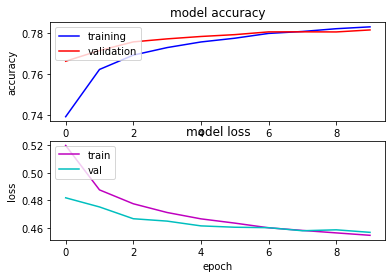

In [43]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['training', 'validation'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

It seems that the model with going to overfit after 10 epochs 

### Testing the model 

In [47]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 3s 68ms/step


In [48]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

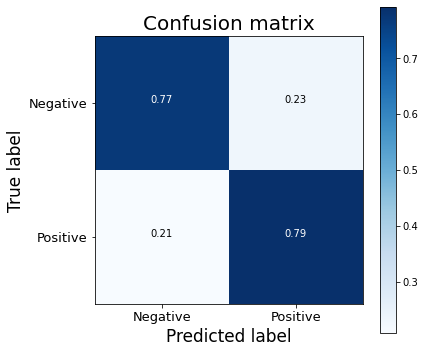

In [49]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [50]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78    160542
    Positive       0.77      0.79      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



## Error analysis

In [ ]:
errors = pd.DataFrame()
texts=[]
sents=[]
preds=[]
for i,(_, row) in enumerate( test_data.iterrows()):
  if row['sentiment'] != y_pred_1d[i]:
    texts.append(row['text'])
    sents.append(row['sentiment'])
    preds.append(y_pred_1d[i])

errors['text']=texts
errors['sentiment']=sents
errors['preds']=preds


In [57]:
errors.head(15)

,text,sentiment,preds
0,haha yuup much alcohol,Negative,Positive
1,understand still dont like oh yourname boring ...,Positive,Negative
2,sorry quot enter quot button got cool mom,Positive,Negative
3,exact thing happened yesterday sure insulted f...,Positive,Negative
4,awww set blind dates hahaha ape yang common an...,Positive,Negative
5,yeah babe mind wanna rip others clothes amp ma...,Positive,Negative
6,umm nice website,Negative,Positive
7,followfriday vin495 internet boyfriend leave s...,Positive,Negative
8,wow small airport spoiled jfk junkprints feel ...,Positive,Negative
9,think violates noncompete,Negative,Positive


It looks like the model is confused because :



1.   there is an errors of labling the data could be from the annotators of the dataset 
2.   some sentences contain the both meanings 



In [46]:
# zipping the best model for downloading 
! zip -r '/content/best_model' '/content/Best_model'

  adding: content/Best_model/ (stored 0%)
  adding: content/Best_model/variables/ (stored 0%)
  adding: content/Best_model/variables/variables.data-00000-of-00001 (deflated 69%)
  adding: content/Best_model/variables/variables.index (deflated 69%)
  adding: content/Best_model/keras_metadata.pb (deflated 91%)
  adding: content/Best_model/assets/ (stored 0%)
  adding: content/Best_model/saved_model.pb (deflated 91%)
